# YGO card Verification Using One Shot Learning

First connect to your drive so you can access to your credentials like your kaggle API code

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Importing Libraries

In [2]:
import tensorflow as tf 
import numpy as np
import os
from keras.layers import Conv2D, Activation, AveragePooling2D, MaxPooling2D, ZeroPadding2D, Input, concatenate
from keras.layers.core import Lambda, Dense, Flatten
from numpy import genfromtxt
import cv2
from keras import backend as K
K.set_image_data_format('channels_last')

from keras.layers import *
from keras.models import Model
from sklearn.preprocessing import normalize
import random
import matplotlib.pyplot as plt
import keras
import sys
import glob
import imgaug.augmenters as iaa
from keras.layers import BatchNormalization
import imgaug.augmenters as iaa
import glob
import pickle
from google.colab import files
import pandas as pd
from tqdm import tqdm

#### Plot the versions

In [3]:
print("Keras version :",keras.__version__)
print("Tensorflow version :",tf.__version__)
print("Python version :",sys.version)

Keras version : 2.9.0
Tensorflow version : 2.9.2
Python version : 3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]


#### Set if the model is already trained or not 
##### If you want to **train** the model, set **model_trained to False**
##### If you want to **test** the model, set **model_trained to True**

###### path of the unziped model downloaded from kaggle

In [4]:
model_trained = False

#If the model is already trained then define the path for the trained weight and the trained dict
model_trained_path = '/content/triplet_model_28k_old_trans.h5'
dict_trained_path = '/content/dict_black_white_244_padded.pkl'

### download the full dataset 
#### This is the 28 000 card version 

you have to change the following line with you path to the kaggle.json file

" !cp /content/drive/MyDrive/DATASET/kaggle.json ~/.kaggle/kaggle.json "




In [7]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/DATASET/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
#if the model is already trained we can download the triplet dict and the .h5 file 
!kaggle datasets download -d axelpuech/model-trained 
! unzip /content/model-trained.zip

100% 200M/200M [00:12<00:00, 23.0MB/s]
100% 200M/200M [00:12<00:00, 17.2MB/s]
Archive:  /content/model-trained.zip
  inflating: dict_28k.pkl            
  inflating: dict_old_trans_28k.pkl  
  inflating: training_with_noise_28k.h5  
  inflating: triplet_model_28k_old_trans.h5  


### Downlaod the full dataset
#### This is the 28K cards version

In [9]:
!kaggle datasets download -d axelpuech/yugioh-28k-dataset

 74% 9.58G/13.0G [08:20<02:59, 20.6MB/s]
User cancelled operation


In [10]:
! unzip /content/yugioh-28k-dataset.zip

Archive:  /content/yugioh-28k-dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/yugioh-28k-dataset.zip or
        /content/yugioh-28k-dataset.zip.zip, and cannot find /content/yugioh-28k-dataset.zip.ZIP, period.


### Download the picture for test

In [16]:
!kaggle datasets download -d axelpuech/scanned-images
! unzip /content/scanned-images.zip

scanned-images.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/scanned-images.zip
replace images scanned/WhatsApp Image 2023-01-24 at 15.40.30 (1).jpegcroped.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Download the cvs file for the card infos

In [17]:
!kaggle datasets download -d axelpuech/card-info-csv
! unzip /content/card-info-csv.zip

card-info-csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/card-info-csv.zip
replace public_Card_YGO.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#### Defining the path of dataset

In [13]:
images_path_full = glob.glob("/content/Dataset_YGO_multi/*/*.jpg")

#### Explore the dataset

In [14]:
# print("the size of the dataset is :",len(images_path))
print("the size of the dataset full is :",len(images_path_full))

the size of the dataset full is : 0


In [6]:
def return_random_path_full():
    dir = random.choice(images_path_full)
    return dir

# augment the data

In [ ]:
def padding_images(image):
    """ this function will randomly pad the image like it was the border of an image of the ygo card."""
    # generate a random value to select  the padding mode 
    padding_mode = random.randint(0, 11)	
    # generate a random value to generate the number of pixel padded
    padding_value1 = random.randint(0, 15)	
    # second random value for double transformation ( ex top left or bot right)
    padding_value2 = random.randint(0, 15)	
    #color of the padding 
    color_pad = (70,90)

    # top
    if padding_mode == 0:
        aug = iaa.CropAndPad(px=((padding_value1),(0),(-padding_value1),(0)),pad_cval=color_pad)
        padded = aug.augment_image(image)
        return padded

    # bot
    if padding_mode == 1:
        aug = iaa.CropAndPad(px=((-padding_value1),(0),(padding_value1),(0)),pad_cval=color_pad)
        padded = aug.augment_image(image)
        return padded

    # left
    if padding_mode == 2:
        aug = iaa.CropAndPad(px=((0),(-padding_value1),(0),(padding_value1)),pad_cval=color_pad)
        padded = aug.augment_image(image)
        return padded

    # right
    if padding_mode == 3:
        aug = iaa.CropAndPad(px=((0),(padding_value1),(0),(-padding_value1)),pad_cval=color_pad)
        padded = aug.augment_image(image)
        return padded

    # top_left
    if padding_mode == 4:
        aug = iaa.CropAndPad(px=((padding_value1),(-padding_value2),(-padding_value1),(padding_value2)),pad_cval=color_pad)
        padded = aug.augment_image(image)
        return padded

    # top_right
    if padding_mode == 5:
        aug = iaa.CropAndPad(px=((padding_value1),(padding_value2),(-padding_value1),(-padding_value2)),pad_cval=color_pad)
        padded = aug.augment_image(image)
        return padded

    # bot_left
    if padding_mode == 6:
        aug = iaa.CropAndPad(px=((-padding_value1),(-padding_value2),(padding_value1),(padding_value2)),pad_cval=color_pad)
        padded = aug.augment_image(image)
        return padded

    # bot_right
    if padding_mode == 7:
        aug = iaa.CropAndPad(px=((-padding_value1),(padding_value2),(padding_value1),(-padding_value2)),pad_cval=color_pad)
        padded = aug.augment_image(image)
        return padded

    # None
    else:
        return image

In [ ]:
# augmentation = iaa.Sequential([
#     iaa.Resize({"height": 614, "width": 421}),
#     iaa.Crop(px=(112, 52, 179, 52),), #top, right, bot, left
#     iaa.Sometimes(0.75, iaa.GaussianBlur(sigma=(0, 2))),
#     # iaa.Sometimes(0.25,iaa.OneOf([iaa.Dropout(p=(0, 0.1)),iaa.CoarseDropout(0.1, size_percent=0.1)])),
#     # iaa.Sometimes(0.25,iaa.AdditiveGaussianNoise(scale=(0, 0.2*255))),
#     iaa.Sometimes(0.20,iaa.AdditiveGaussianNoise(scale=(0,20))),
#     # iaa.Dropout(p=(0, 0.1)),
#     # iaa.SaltAndPepper(0.05),
#     iaa.Sometimes(0.30,iaa.CoarseDropout((0.0, 0.01), size_percent=(0.25, 0.25),per_channel=0.5)),
#     iaa.CropAndPad(px=(-20, 20),sample_independently=False,pad_cval = (70,90)), 

    
#     iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True),
#     iaa.Multiply((0.8,1.2)),
#     iaa.LinearContrast((0.8,1.2)),
#     iaa.MultiplyAndAddToBrightness(mul=(0.8, 1.2), add=(-20, 20)),
#     iaa.MultiplyHueAndSaturation(mul_hue=(0.8, 1.2)),
#     iaa.GammaContrast((0.8, 1.0), per_channel=True),
#     iaa.Resize({"height": 244, "width": 244}),
#     iaa.Grayscale(alpha=1.0)
# ])
augmentation = iaa.Sequential([
    iaa.Resize({"height": 614, "width": 421}),
    iaa.Crop(px=(112, 52, 179, 52),), #top, right, bot, left
    iaa.Sometimes(0.75, iaa.GaussianBlur(sigma=(0, 3.0))),
    # iaa.Sometimes(0.25,iaa.OneOf([iaa.Dropout(p=(0, 0.1)),iaa.CoarseDropout(0.1, size_percent=0.1)])),
    iaa.Sometimes(0.30,iaa.CoarseDropout((0.0, 0.01), size_percent=(0.25, 0.25),per_channel=0.5)),
    iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True),
    iaa.Multiply((0.7,1.3)),
    iaa.LinearContrast((0.7,1.3)),
    iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30)),
    iaa.MultiplyHueAndSaturation(mul_hue=(0.5, 1.5)),
    iaa.GammaContrast((0.5, 1.0), per_channel=True),
    iaa.Resize({"height": 244, "width": 244}),
    iaa.Grayscale(alpha=1.0)
])

augmentation_anchor = iaa.Sequential([
    iaa.Resize({"height": 614, "width": 421}),
#     iaa.WithBrightnessChannels(iaa.Add(10)),
    iaa.Crop(px=(112, 52, 179, 52),), #top, right, bot, left
    iaa.Resize({"height": 244, "width": 244}),
    iaa.Grayscale(alpha=1.0)

])


def augment_img_iaa(path_img, positive, transpose_and_normalize = True):
    """ This function will apply random transformation on an image
    - The first argument is the path of the image
    - The second argument is to say if the image we gonna transform is the positive image
    - transpose and normalize is used to transform image to feed the nn
    
    The transformation applyed are randomly : increse or deacrease brightness, add saturation,
    add contrast and crop and resize the card to keep only the image of the monster."""
    
    augmented_images = cv2.imread(path_img)
    temp_list_4aug = [augmented_images]

    if positive:

        augmented_images  = augmentation(images = temp_list_4aug )
        augmented_images = augmented_images[0]
        augmented_images = padding_images(augmented_images)
        
    else : 
        augmented_images = augmentation_anchor(images = temp_list_4aug )
        augmented_images = augmented_images[0]

    if transpose_and_normalize:
        # augmented_images=np.transpose(augmented_images,(2,0,1))
        augmented_images=augmented_images.astype('float32')/255.0


    return augmented_images

# Plot the image

In [ ]:
def plot_images(path1, path2 = None):
    """the first path is the path that will be augmented the second is the anchor one
    This function will plot the 2 images side to side"""
    augmented_img = augment_img_iaa(path1, True, False)

    if path2:
        anchor_image = augment_img_iaa(path2, False, False) 

        fig=plt.figure(figsize=(10,10))
        ax1 = fig.add_subplot(2,2,1)
        ax1.imshow(augmented_img)
        ax2 = fig.add_subplot(2,2,2)
        ax2.imshow(anchor_image)
    else : 
        plt.imshow(cv2.cvtColor(augmented_img, cv2.COLOR_BGR2RGB))
        plt.show()

#### test the output shape of the image augmentor

In [ ]:
test_path = return_random_path_full()
print(test_path)
test = augment_img_iaa(test_path, True)
print('test.shape : ', test.shape)

/content/Dataset_YGO_multi/27897/13032.jpg
test.shape :  (244, 244, 3)


#### exemple of 3 images augmented, on the left there is the augmented image and on the right the original image

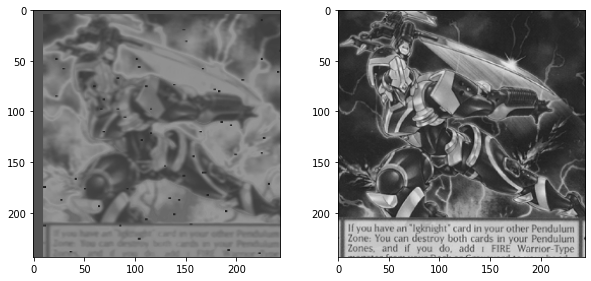

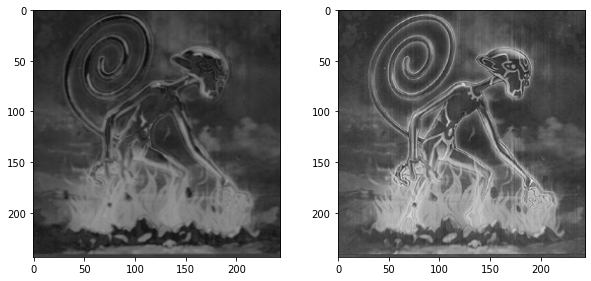

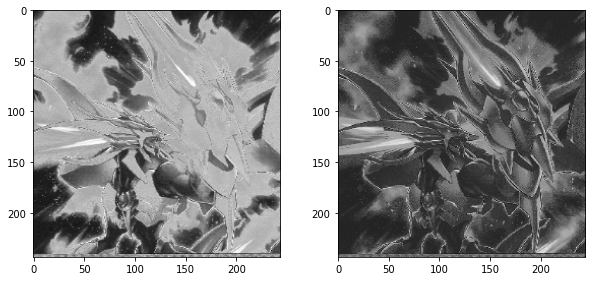

In [ ]:
for i in range(3):
    test_path = return_random_path_full()
    plot_images(test_path,test_path)

# Defining the Model

In [ ]:
def inception_block_1a(X):

    # print('\n\ninception_block_1a \n' )
    X_3=Conv2D(244,(1,1),data_format='channels_last',name='inception_3a_3x3_conv1')(X)
    X_3=BatchNormalization(axis=3,epsilon=0.00001,name='inception_3a_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_last')(X_3)
    X_3=Conv2D(128,(3,3),data_format='channels_last',name='inception_3a_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=3,epsilon=0.00001,name='inception_3a_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    print('X_3.shape : ', X_3.shape)
    
    X_5=Conv2D(16,(1,1),data_format='channels_last',name='inception_3a_5x5_conv1')(X)
    X_5=BatchNormalization(axis=3,epsilon=0.00001,name='inception_3a_5x5_bn1')(X_5)
    X_5=Activation('relu')(X_5)
    X_5=ZeroPadding2D(padding=(2,2),data_format='channels_last')(X_5)
    X_5=Conv2D(32,(5,5),data_format='channels_last',name='inception_3a_5x5_conv2')(X_5)
    X_5=BatchNormalization(axis=3,epsilon=0.00001,name='inception_3a_5x5_bn2')(X_5)
    X_5=Activation('relu')(X_5)
    print('X_5.shape', X_5.shape)
    
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_last')(X)
    X_pool = Conv2D(32, (1, 1), data_format='channels_last', name='inception_3a_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=((8, 8), (8,8)), data_format='channels_last')(X_pool)
    print('X_pool.shape', X_pool.shape)
    # zeropadding :  top bot left right

    X_1=Conv2D(64,(1,1),data_format='channels_last',name='inception_3a_1x1_conv')(X)
    X_1=BatchNormalization(axis=3,epsilon=0.00001,name='inception_3a_1x1_bn')(X_1)
    X_1=Activation('relu')(X_1)
    print('X_1.shape', X_1.shape)
    
    inception=concatenate([X_3,X_5,X_pool,X_1],axis=3)
    return inception

def inception_block_1b(X):
    print('\n\ninception_block_1b \n' )

    X_3=Conv2D(244,(1,1),data_format='channels_last',name='inception_3b_3x3_conv1')(X)
    X_3=BatchNormalization(axis=3,epsilon=0.00001,name='inception_3b_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_last')(X_3)
    X_3=Conv2D(128,(3,3),data_format='channels_last',name='inception_3b_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=3,epsilon=0.00001,name='inception_3b_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    print('X_3.shape', X_3.shape)

    
    X_5=Conv2D(32,(1,1),data_format='channels_last',name='inception_3b_5x5_conv1')(X)
    X_5=BatchNormalization(axis=3,epsilon=0.00001,name='inception_3b_5x5_bn1')(X_5)
    X_5=Activation('relu')(X_5)
    X_5=ZeroPadding2D(padding=(2,2),data_format='channels_last')(X_5)
    X_5=Conv2D(64,(5,5),data_format='channels_last',name='inception_3b_5x5_conv2')(X_5)
    X_5=BatchNormalization(axis=3,epsilon=0.00001,name='inception_3b_5x5_bn2')(X_5)
    X_5=Activation('relu')(X_5)
    print('X_5.shape', X_5.shape)

    
    X_P=AveragePooling2D(pool_size=(3,3),strides=(3,3),data_format='channels_last')(X)
    X_P=Conv2D(64,(1,1),data_format='channels_last',name='inception_3b_pool_conv')(X_P)
    X_P=BatchNormalization(axis=3,epsilon=0.00001,name='inception_3b_pool_bn')(X_P)
    X_P=Activation('relu')(X_P)
    X_P=ZeroPadding2D(padding=((10, 11), (10,11)),data_format='channels_last')(X_P)
    print('X_P.shape', X_P.shape)

    
    X_1=Conv2D(64,(1,1),data_format='channels_last',name='inception_3b_1x1_conv')(X)
    X_1=BatchNormalization(axis=3,epsilon=0.00001,name='inception_3b_1x1_bn')(X_1)
    X_1=Activation('relu')(X_1)
    print('X_1.shape', X_1.shape)


    inception=concatenate([X_3,X_5,X_P,X_1],axis=3)
    return inception

def inception_block_1c(X):
    print('\n\ninception_block_1c \n' )

    X_3=Conv2D(128,(1,1),data_format='channels_last',name='inception_3c_3x3_conv1')(X)
    X_3=BatchNormalization(axis=3,epsilon=0.00001,name='inception_3c_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_last')(X_3)
    X_3=Conv2D(256,(3,3),strides=(2,2),data_format='channels_last',name='inception_3c_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=3,epsilon=0.00001,name='inception_3c_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    print('X_3.shape', X_3.shape)

    
    X_5=Conv2D(32,(1,1),data_format='channels_last',name='inception_3c_5x5_conv1')(X)
    X_5=BatchNormalization(axis=3,epsilon=0.00001,name='inception_3c_5x5_bn1')(X_5)
    X_5=Activation('relu')(X_5)
    X_5=ZeroPadding2D(padding=(2,2),data_format='channels_last')(X_5)
    X_5=Conv2D(64,(5,5),strides=(2,2),data_format='channels_last',name='inception_3c_5x5_conv2')(X_5)
    X_5=BatchNormalization(axis=3,epsilon=0.00001,name='inception_3c_5x5_bn2')(X_5)
    X_5=Activation('relu')(X_5)
    print('X_5.shape', X_5.shape)

    
    X_P=MaxPooling2D(pool_size=3,strides=2,data_format='channels_last')(X)
    X_P=ZeroPadding2D(padding=((0,1),(0,1)),data_format='channels_last')(X_P)
    print('X_P.shape', X_P.shape)


    inception=concatenate([X_3,X_5,X_P],axis=3)
    return inception

def inception_block_2a(X):
    print('\n\ninception_block_2a \n' )

    X_3=Conv2D(244,(1,1),data_format='channels_last',name='inception_4a_3x3_conv1')(X)
    X_3=BatchNormalization(axis=3,epsilon=0.00001,name='inception_4a_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_last')(X_3)
    X_3=Conv2D(192,(3,3),data_format='channels_last',name='inception_4a_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=3,epsilon=0.00001,name='inception_4a_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    print('X_3.shape', X_3.shape)

    
    X_5=Conv2D(32,(1,1),data_format='channels_last',name='inception_4a_5x5_conv1')(X)
    X_5=BatchNormalization(axis=3,epsilon=0.00001,name='inception_4a_5x5_bn1')(X_5)
    X_5=Activation('relu')(X_5)
    X_5=ZeroPadding2D(padding=(2,2),data_format='channels_last')(X_5)
    X_5=Conv2D(64,(5,5),data_format='channels_last',name='inception_4a_5x5_conv2')(X_5)
    X_5=BatchNormalization(axis=3,epsilon=0.00001,name='inception_4a_5x5_bn2')(X_5)
    X_5=Activation('relu')(X_5)
    print('X_5.shape', X_5.shape)

    
    X_P=AveragePooling2D(pool_size=(3,3),strides=(3,3),data_format='channels_last')(X)
    X_P=Conv2D(128,(1,1),data_format='channels_last',name='inception_4a_pool_conv')(X_P)
    X_P=BatchNormalization(axis=3,epsilon=0.00001,name='inception_4a_pool_bn')(X_P)
    X_P=Activation('relu')(X_P)
    X_P=ZeroPadding2D(padding=((5, 6), (5,6)),data_format='channels_last')(X_P)
    print('X_P.shape', X_P.shape)

    
    X_1=Conv2D(256,(1,1),data_format='channels_last',name='inception_4a_1x1_conv')(X)
    X_1=BatchNormalization(axis=3,epsilon=0.00001,name='inception_4a_1x1_bn')(X_1)
    X_1=Activation('relu')(X_1)
    print('X_1.shape', X_1.shape)


    inception=concatenate([X_3,X_5,X_P,X_1],axis=3)
    return inception

def inception_block_2b(X):
    print('\n\ninception_block_2b\n' )

    X_3=Conv2D(160,(1,1),data_format='channels_last',name='inception_4e_3x3_conv1')(X)
    X_3=BatchNormalization(axis=3,epsilon=0.00001,name='inception_4e_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_last')(X_3)
    X_3=Conv2D(256,(3,3),strides=(2,2),data_format='channels_last',name='inception_4e_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=3,epsilon=0.00001,name='inception_4e_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    print('X_3.shape', X_3.shape)
    
    X_5=Conv2D(64,(1,1),data_format='channels_last',name='inception_4e_5x5_conv1')(X)
    X_5=BatchNormalization(axis=3,epsilon=0.00001,name='inception_4e_5x5_bn1')(X_5)
    X_5=Activation('relu')(X_5)
    X_5=ZeroPadding2D(padding=(2,2),data_format='channels_last')(X_5)
    X_5=Conv2D(128,(5,5),strides=(2,2),data_format='channels_last',name='inception_4e_5x5_conv2')(X_5)
    X_5=BatchNormalization(axis=3,epsilon=0.00001,name='inception_4e_5x5_bn2')(X_5)
    X_5=Activation('relu')(X_5)
    print('X_5.shape', X_5.shape)

    X_P=MaxPooling2D(pool_size=3,strides=2,data_format='channels_last')(X)
    X_P=ZeroPadding2D(padding=((0,1),(0,1)),data_format='channels_last')(X_P)
    print('X_P.shape', X_P.shape)
    
    inception=concatenate([X_3,X_5,X_P],axis=3)
    return inception

def inception_block_3a(X):
    print('\n\ninception_block_3a\n' )
    
    X_3=Conv2D(244,(1,1),data_format='channels_last',name='inception_5a_3x3_conv1')(X)
    X_3=BatchNormalization(axis=3,epsilon=0.00001,name='inception_5a_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_last')(X_3)
    X_3=Conv2D(384,(3,3),data_format='channels_last',name='inception_5a_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=3,epsilon=0.00001,name='inception_5a_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    print('X_3.shape', X_3.shape)

    X_P=AveragePooling2D(pool_size=(3,3),strides=(3,3),data_format='channels_last')(X)
    X_P=Conv2D(244,(1,1),data_format='channels_last',name='inception_5a_pool_conv')(X_P)
    X_P=BatchNormalization(axis=3,epsilon=0.00001,name='inception_5a_pool_bn')(X_P)
    X_P=Activation('relu')(X_P)
    X_P=ZeroPadding2D(padding=(3,3),data_format='channels_last')(X_P)
    print('X_P.shape', X_P.shape)

    X_1=Conv2D(256,(1,1),data_format='channels_last',name='inception_5a_1x1_conv')(X)
    X_1=BatchNormalization(axis=3,epsilon=0.00001,name='inception_5a_1x1_bn')(X_1)
    X_1=Activation('relu')(X_1)
    print('X_1.shape', X_1.shape)

    inception=concatenate([X_3,X_P,X_1],axis=3)
    return inception
def inception_block_3b(X):
    X_3=Conv2D(244,(1,1),data_format='channels_last',name='inception_5b_3x3_conv1')(X)
    X_3=BatchNormalization(axis=3,epsilon=0.00001,name='inception_5b_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_last')(X_3)
    X_3=Conv2D(384,(3,3),data_format='channels_last',name='inception_5b_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=3,epsilon=0.00001,name='inception_5b_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    
    
    X_P=MaxPooling2D(pool_size=(3,3),strides=2,data_format='channels_last')(X)
    X_P=Conv2D(244,(1,1),data_format='channels_last',name='inception_5b_pool_conv')(X_P)
    X_P=BatchNormalization(axis=3,epsilon=0.00001,name='inception_5b_pool_bn')(X_P)
    X_P=Activation('relu')(X_P)
    X_P=ZeroPadding2D(padding=((2, 3), (2,3)),data_format='channels_last')(X_P)
    
    X_1=Conv2D(256,(1,1),data_format='channels_last',name='inception_5b_1x1_conv')(X)
    X_1=BatchNormalization(axis=3,epsilon=0.00001,name='inception_5b_1x1_bn')(X_1)
    X_1=Activation('relu')(X_1)

    inception=concatenate([X_3,X_P,X_1],axis=3)
    return inception


def FinalModel(input_shape):
    
    X_input=Input(input_shape)
    
    X=ZeroPadding2D(padding=(3,3))(X_input)
    X=Conv2D(64,(7,7),strides=(2,2),name='conv1')(X)
    X=BatchNormalization(axis=3,name='bn1')(X)
    X=Activation('relu')(X)
    
    X=ZeroPadding2D((1,1))(X)
    X=MaxPooling2D((3,3),strides=2)(X)
    
    X=Conv2D(64,(1,1),strides=(1,1),name='conv2')(X)
    X=BatchNormalization(axis=3,epsilon=0.00001,name='bn2')(X)
    X=Activation('relu')(X) 
    
    X=ZeroPadding2D(padding=(1,1))(X)
    
    X=Conv2D(192,(3,3),strides=(1,1),name='conv3')(X)
    X=BatchNormalization(axis=3,epsilon=0.00001,name='bn3')(X)
    X=Activation('relu')(X)
    
    X=ZeroPadding2D(padding=(1,1))(X)
    X=MaxPooling2D(pool_size=(3,3),strides=(2,2))(X)
    
    X=inception_block_1a(X)
    X=inception_block_1b(X)
    X=inception_block_1c(X)
    
    X=inception_block_2a(X)
    X=inception_block_2b(X)
    
    X=inception_block_3a(X)
    X=inception_block_3b(X)
    
    X=AveragePooling2D(pool_size=(3,3),strides=(1,1),data_format='channels_last')(X)
    X=Flatten()(X)
    X=Dense(128,activation='relu',kernel_initializer='glorot_normal',name='dense_layer')(X)
    X=Lambda(lambda x:K.l2_normalize(x,axis=1),name='lambda_1')(X)
    
    model=Model(inputs=X_input,outputs=X,name='CardRecogModel')
    return model    


In [ ]:
model=FinalModel(input_shape=(244,244,3))

# Defining the Triplet Loss Function

In [ ]:
def triplet_loss_t(y_true,y_pred):
    print(y_pred)
    anchor=y_pred[:,0:128]
    pos=y_pred[:,128:256]
    neg=y_pred[:,256:384]
    
    positive_distance = K.sum(K.abs(anchor-pos), axis=1)
    negative_distance = K.sum(K.abs(anchor-neg), axis=1)
    probs=K.softmax([positive_distance,negative_distance],axis=0)
    #loss = positive_distance - negative_distance+alpha
    loss=K.mean(K.abs(probs[0])+K.abs(1.0-probs[1]))
    return loss

## Definig the generator

In [ ]:
def data_gen(batch_size=32):
    """ The data generator will give to the model 3 images, this first one is the anchor:
    so its a random image choosen in the dataset, the second is the positive:
    its the first image but with transformation and the third one is the negative: its a different picture in the dataset"""
    while True:
        i=0
        positive=[]
        anchor=[]
        negative=[]    
        

        while(i<batch_size):

            dir1 = return_random_path_full()
            dir2 = return_random_path_full()

            pos_img = augment_img_iaa(dir1,True)
            anc_img = augment_img_iaa(dir1, False)
            # Not applying augmentation to the negative image by setting the second parameter to False
            neg_img = augment_img_iaa(dir2,False)

            positive.append(list(pos_img))

            negative.append(list(neg_img))

            anchor.append(list(anc_img))

            i=i+1
        #return anchor,positive,negative
        yield ([np.array(anchor),np.array(positive),np.array(negative)],np.zeros((batch_size,1)).astype("float32"))

## Defining model for triplet loss

In [ ]:
triplet_model_a=Input((244,244,3))
triplet_model_n=Input((244,244,3))
triplet_model_p=Input((244,244,3))
triplet_model_out=Concatenate()([model(triplet_model_a),model(triplet_model_p),model(triplet_model_n)])
triplet_model=Model([triplet_model_a,triplet_model_p,triplet_model_n],triplet_model_out)

In [ ]:
triplet_model.compile(optimizer='adam',loss=triplet_loss_t)

## Training the model
> We will be training the model for 7 epoch and with steps_per_epoch as 400  .These hyperparameters can be changed as per the availablity of computional power

>  Since batch size is 32 and total number of samples is almost 28k so steps_per_epoch=400

### Once the model finished the training it will be donwloaded 

In [ ]:
if model_trained == False:
    triplet_model.fit(data_gen(),steps_per_epoch=400,epochs=7)
    triplet_model.save('triplet_model_28k_old_trans.h5')
    files.download('triplet_model_28k_old_trans.h5')

Epoch 1/7
Tensor("model/concatenate_7/concat:0", shape=(None, 384), dtype=float32)
Tensor("model/concatenate_7/concat:0", shape=(None, 384), dtype=float32)
400/400 [==============================] - 930s 2s/step - loss: 0.2494
Epoch 2/7
400/400 [==============================] - 907s 2s/step - loss: 0.0568
Epoch 3/7
400/400 [==============================] - 904s 2s/step - loss: 0.0372
Epoch 4/7
400/400 [==============================] - 903s 2s/step - loss: 0.0275
Epoch 5/7
400/400 [==============================] - 911s 2s/step - loss: 0.0271
Epoch 6/7
400/400 [==============================] - 912s 2s/step - loss: 0.0249
Epoch 7/7
400/400 [==============================] - 906s 2s/step - loss: 0.0237


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
" if the model is already trained, we just need to load the model trained"
if model_trained == True:
    triplet_model=keras.models.load_model(model_trained_path,custom_objects={'triplet_loss_t':triplet_loss_t})

### We read the csv file 

In [ ]:
df = pd.read_csv('/content/public_Card_YGO.csv') 
display(df)


### We Clean the CSV file

In [ ]:
def clean_the_dataset(df):
  col_names = list(df.columns)
  list_to_remove = ['name', 'set_code', 'image_url', 'id_card','id']
  final_list = list(set(col_names) - set(list_to_remove))
  df_clean = df.drop(final_list, axis = 1,inplace= False)

  num_image_url_Nan = df['image_url'].isna().sum()
  num_image_url_yugipedia_Nan = df['image_url_yugipedia'].isna().sum()
  num_image_url_cm_Nan = df['image_url_cm'].isna().sum()
  print('num_image_url_Nan: ',num_image_url_Nan,', image_url_yugipedia :', num_image_url_yugipedia_Nan,', num_image_url_cm_Nan',num_image_url_cm_Nan  )
  
  
  df_clean =df_clean.dropna(subset=['image_url'])
  df_clean.reset_index(drop=True, inplace=True)
  return df_clean


In [ ]:
df_cleaned = clean_the_dataset(df)
df_cleaned.set_index("id", inplace=True)
display(df_cleaned)

In [ ]:
df_cleaned.loc[2554].at["name"]

"Cadeau de l'Elfe Mystique"

# **Implementation of the model**

## Function to preprocess the image according to the model requirements. 

In [ ]:
#To loacalize the mignature and resize the image
def image_resizing(path_image_to_test, test_on_dataset = False):
    image = augment_img_iaa(path_image_to_test, test_on_dataset, False)
    return image


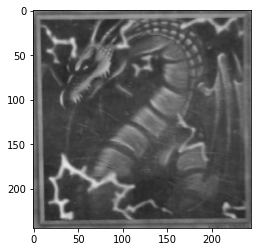

In [ ]:
image_to_test_path = '/content/images scanned/WhatsApp Image 2023-01-24 at 15.40.30 (1).jpegcroped.jpg'
test = image_resizing(image_to_test_path)
plt.imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))
plt.show()

## Function to convert the image to embeddings.

>It normalizes the image matrix and transpose it since here we are using the 'Channels First' data format. Then it uses the base model to predict the embedding for the provided image

In [ ]:
def encode_img(img1,triplet_model):
    #img1=cv2.imread(path,1)
    img=img1[...,::-1]
    # img=np.around(np.transpose(img,(2,0,1))/255,decimals=12)
    img=np.around(img/255,decimals=12)
    x_train=np.array([img])
    emb=triplet_model.layers[3].predict_on_batch(x_train)
    return emb

## Function to calculate the distance between the embeddings and confidence score

>  Selecting the threshold value as 0.5 and intervals means that +/- 0.1 the model confidence score will be 100%.

In [ ]:
threshold=0.50
interval=0.2
def confidence_value(ref_encode,img_encode,thres=threshold):
    #diff=np.max(img_encode-ref_encode)
    dist=np.linalg.norm((img_encode-ref_encode))
    #confidence=(1-K.eval(tf.minimum(dist,1)))
    confidence=(threshold-max([dist,interval]))/(threshold-interval)
    return dist,confidence

In [ ]:
def plot_and_compare(path_image, path_image2 = None):
    """ plot 2 images side to side and compute if the images math and with wich confidence"""
    
    if not path_image2:
        rimg=image_resizing(path_image, True)
        img=image_resizing(path_image)
    else :
        rimg=image_resizing(path_image)
        img=image_resizing(path_image2) 



    fig=plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(rimg)
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(img)


    r_encode=encode_img(rimg,triplet_model)
    img_encode=encode_img(img,triplet_model)
    dist,conf=confidence_value(r_encode,img_encode)
    if dist<threshold:
        print("Match with a confidence of ",conf*100)
        #print("Distance ",dist)
    else:
        print("No Match with a confidence of ",abs(conf*100))

    return None

# For image of the same card but transformed

Match with a confidence of  35.59885422388713


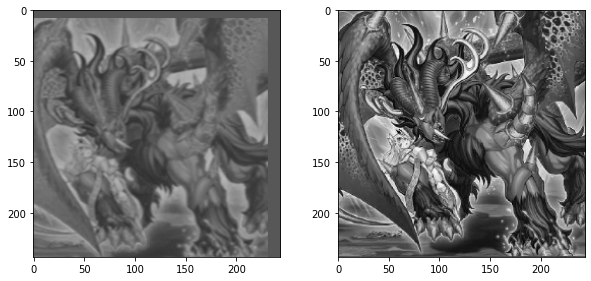

In [ ]:
path_image= '/content/Dataset_YGO_multi/10001/15510.jpg'
plot_and_compare(path_image)

# Creation of a dictionary containing the name of the card and the output of the model when we passed in the given card


#### Get the name of the folder to have the name of the card

In [ ]:
# this function take the images path and return only the name of the card

def return_card_name(img_path):
    card_folder = img_path.split('/')[3] # the name of the card is at the 3th position in the path name
    card_name = card_folder.split('-0-')[0]
    card_name = card_name.replace('-', ' ')
    return card_name

In [ ]:
def return_card_name_from_csv(img_path):
    card_folder = img_path.split('/')[3] # the name of the card is at the 3th position in the path name
    # print(card_folder)
    card_name = df_cleaned.loc[int(card_folder)].at["name"]

    return card_name

In [ ]:
list_id = list(df.id)

#### Creation of a list of tuples : (card name , tensor) in order to create then the dictionary

In [ ]:
if model_trained == False:
    
    tuples_names_emb_list = []
    for i in tqdm(images_path_full):
        img=image_resizing(i)
        tuples_names_emb_list.append((return_card_name_from_csv(i), encode_img(img,triplet_model)))
    names_and_emb_dict = {key: value for (key, value) in tuples_names_emb_list}

100%|██████████| 28556/28556 [15:21<00:00, 30.99it/s]


#### Now we save the dictionnay

In [ ]:
if model_trained == False:
    
    # Open a file for writing
    with open('dict_black_white_244_padded.pkl', 'wb') as f:
      # Write the dictionary to the file
      pickle.dump(names_and_emb_dict, f)
    files.download('dict_black_white_244_padded.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### If the model is already trained and the dict already created, we just have to load it

In [ ]:
if model_trained == True:
    
    with open(dict_trained_path, 'rb') as f:
      # Load the dictionary from the file
      names_and_emb_dict = pickle.load(f)

    # Print one element of the dictionary to test it
#     print(names_and_emb_dict['Gagaga Head']) 

# Compare the output of the model with the dictionnary

In [ ]:
def compare_img_with_dict(image_to_test_path):
    """ This function take a path of an image an return a list of card names,
    the cards names are sorted by the more revelant to the less revelant 
    
    So the first name of the list should be the name of the given card image"""
    
    list_card_name = []
    img=image_resizing(image_to_test_path)
    encoded_img = encode_img(img,triplet_model)
  
    for a in names_and_emb_dict:
        image_dict_encoded = names_and_emb_dict[a]
        dist,conf=confidence_value(encoded_img,image_dict_encoded)
        if dist<threshold:
            if conf > 0.0:
                list_card_name.append((a,conf))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    list_card_name = sorted(list_card_name, key=lambda x: x[1], reverse=True)
    return list_card_name

#### Test of the model 

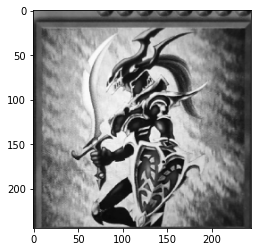

[('Soldat du Lustre Noir', 1.0)]


In [ ]:
card_path_to_test = '/content/images scanned/WhatsApp Image 2023-01-24 at 16.04.13 (1).jpegcroped.jpg'
card_name = compare_img_with_dict(card_path_to_test)
print(card_name)

# print time
# print(%timeit)